## Libraries

In [1]:
import tempfile
import math
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
import pandas as pd 
import seaborn as sns
from statistics import *
import shutil
import sys
import time
from matplotlib.ticker import FormatStrFormatter

#read in printFolder, makeDefNameList, newFolder, deleteFolder, readOutput from coreFunctions.py
from coreFunctions import *

#read in plotting functionality from plottingFunctions.py
from plottingFunctions import *

call("rm -rf tmp*",shell=True)

dfModel = []#will contain output from our model

## Enter Custom Inputs, then Run the Model

Equilibrium Reached at Temp=197.716. At time=6.0
Final Temp(K): 215.56
Final Temp(F): -71.66

False


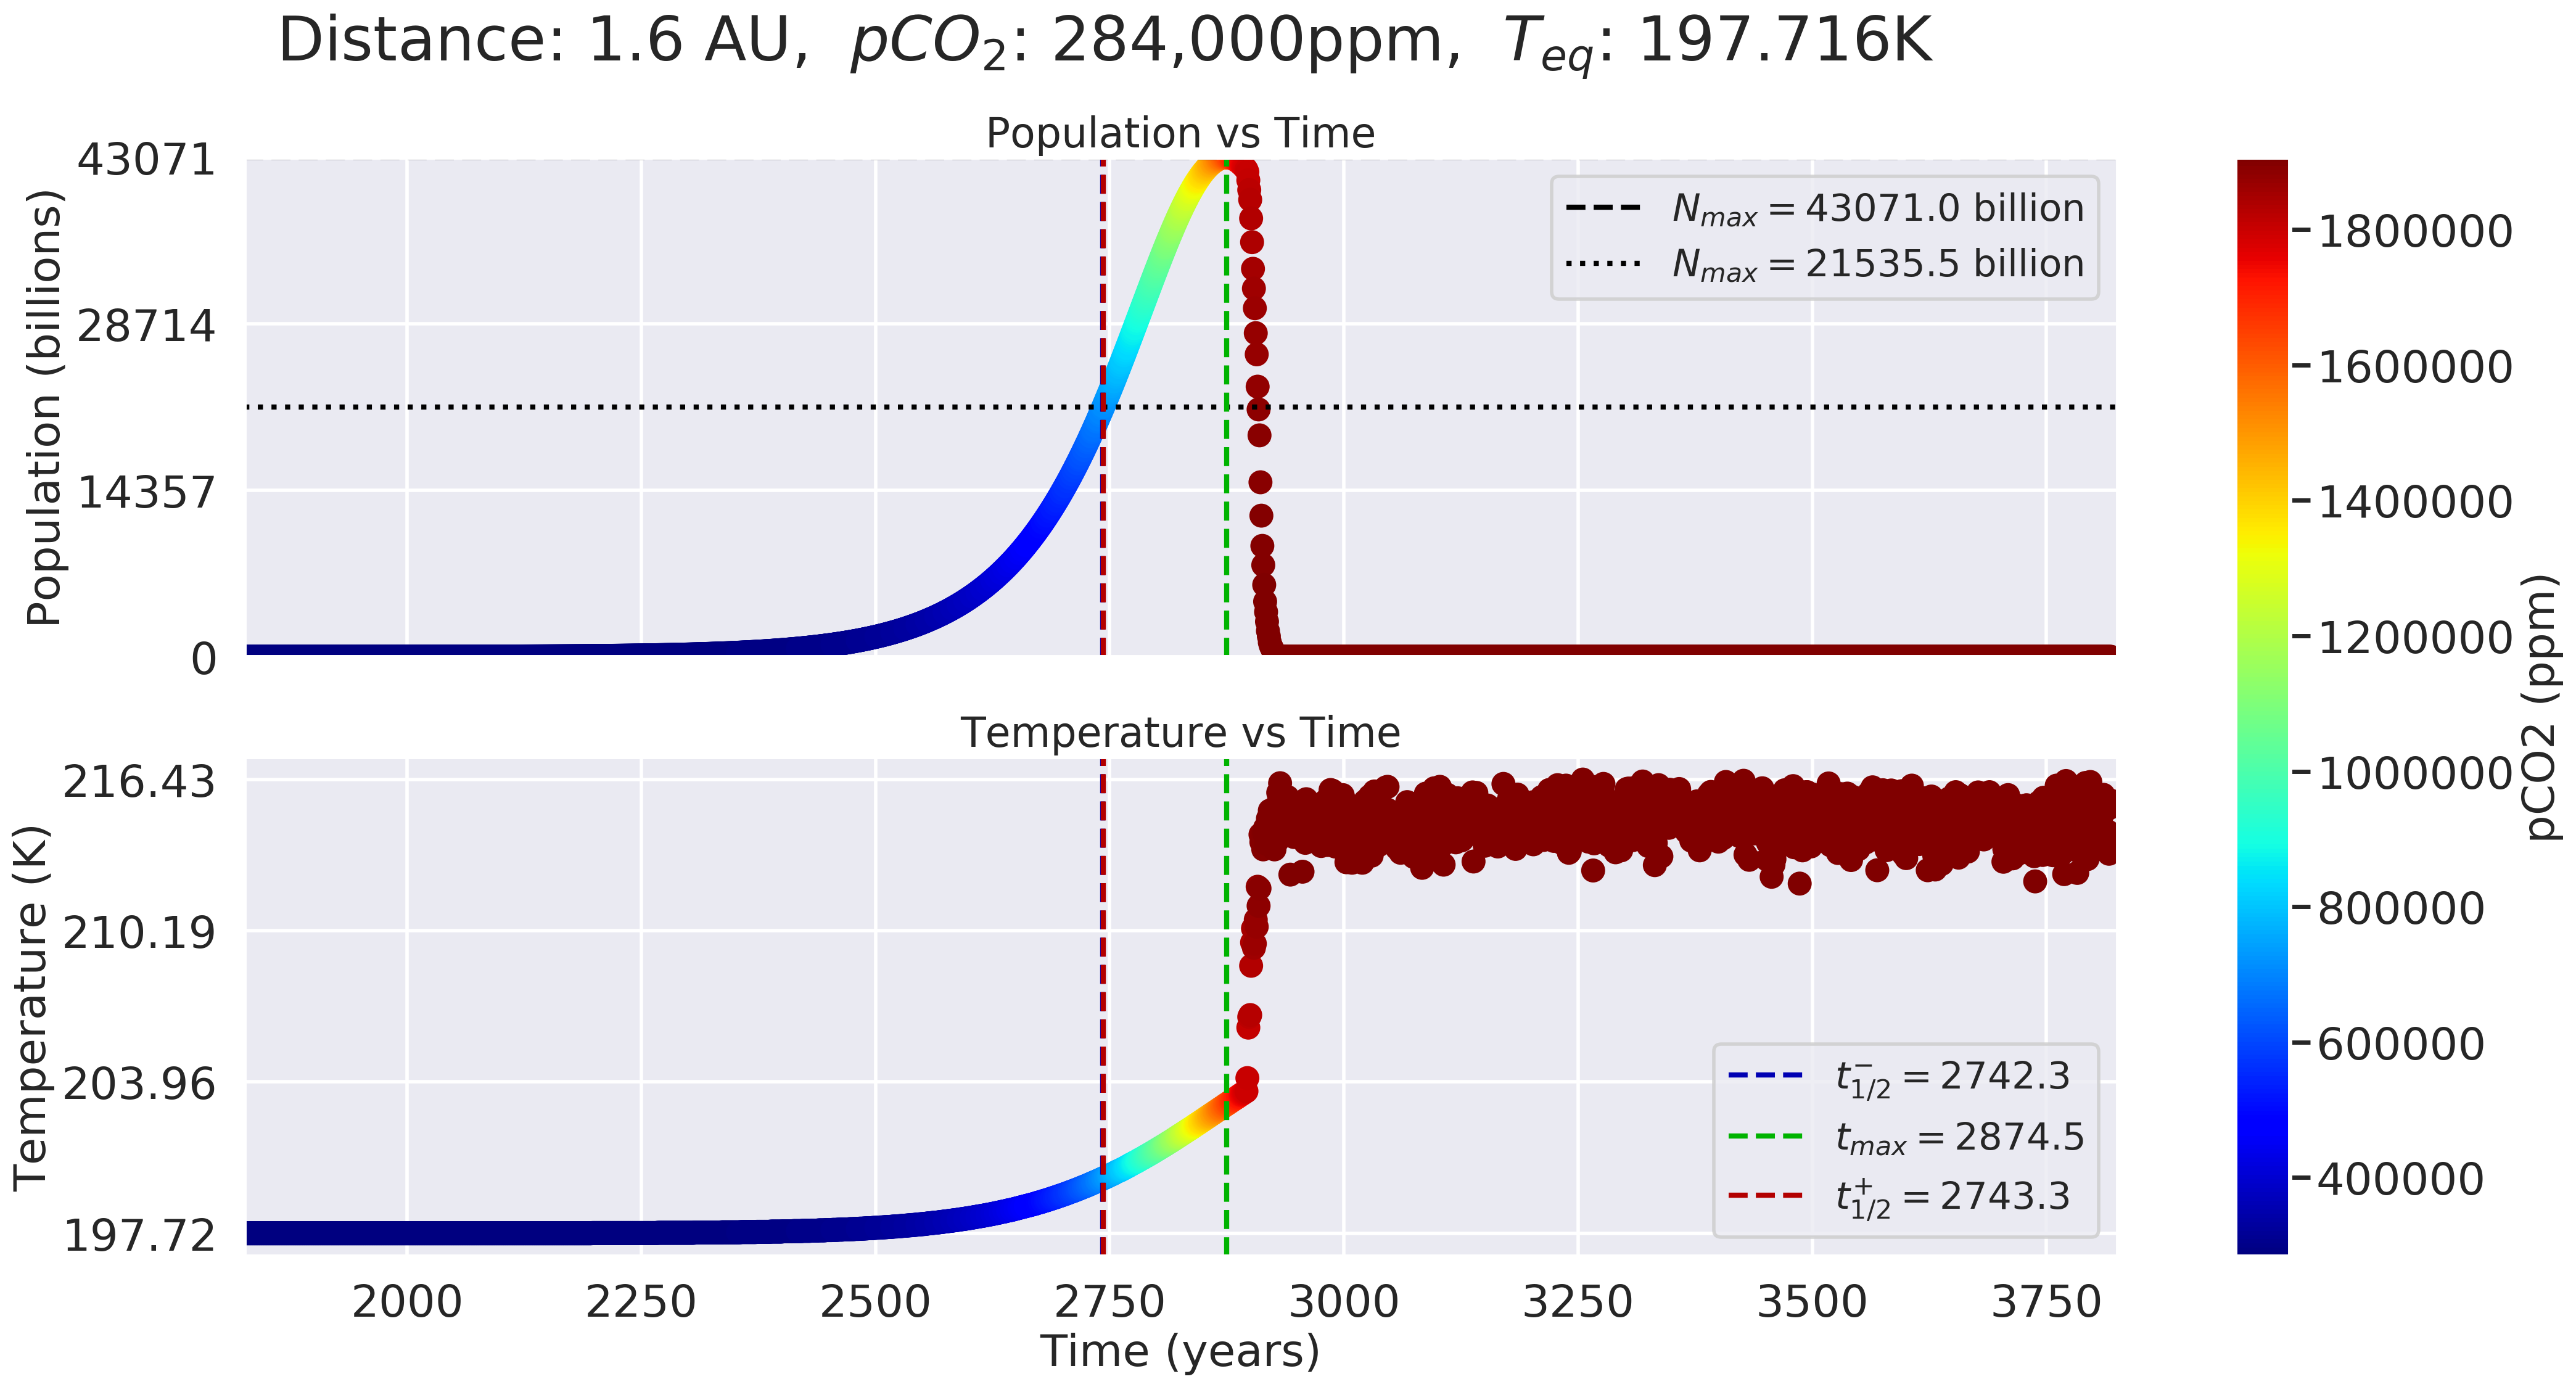

In [2]:
nameList = makeDefNamelist() #make namelist
nameList['ebm']['lverbose']=False #controls terminal output, used for debugging
nameList['ebm']['rBirth']=.0252;
nameList['ebm']['rDeath']=.0142857;
nameList['ebm']['rco2']=2.00e-4;

#specify inputs
nameList['ebm']['coupled']=True;
runTime=2000#change runtime(years)
newA = 1.6#change distance (AU)
newPco2=284*1000#change pco2 (ppm)

#run the program
nameList['ebm']['pco20']=newPco2/10**6#convert pco2 to bars
nameList['ebm']['relsolcon']=newA**-2 #inverse square law for solar flux
nameList['ebm']['runTime'] = runTime#change runtime
dfModel, finalavgtemp, eqTime, eqTemp, equilibrium = runProgram("driver.exe",nameList)

#determine habitability
life = (equilibrium) and (eqTemp<=373.15) and (eqTemp>=273.15)
print(life)

#plot the results
saveName=2;
popStats = analyzeRun(dfModel,nameList,False)#get population statistics
popStats['maxPopPlot']=popStats['maxPop'];#maximum population range
inputs=[newA,newPco2,runTime]
save=True;#save the file
show=False;#show the file
if equilibrium: plotModelOutput(dfModel,inputs,eqTime,eqTemp,popStats,save,saveName)#plot the output of our model, colored by pco2 

## Model Analysis

In [3]:
#dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
#dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
#plotModelInput(nameList)#plot the temperature dependence on the growth rate
#plotTruePopCo2(dfPopCo2) #plot true population values vs pco2
#compareModelOutput(dfModel,dfTemp,dfPopCo2)#compare the models output to true data